# **Universidad Icesi - Maestría en Ciencia de Datos**
## Parcial Práctico de Series de Tiempo
## Daniel Martinez & Felipe Montenegro

# **Sección 1 - Librerías**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.lines as mlines
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# **Sección 2 - Lectura de Datos**

In [3]:
data = pd.read_csv("Examen.csv")
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


# **Sección 3 - Análisis Descriptivo**

Teniendo en cuenta que no tenemos la variable tiempo, es necesario modificar la colmna "Unnamed" y definir la fecha de inicio de la serie.

In [4]:
# Cargar el dataset
data = pd.read_csv('Examen.csv')

# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Crear una serie de fechas a partir de enero de 2008, asignándolas a la columna 'Mes'
data['Mes'] = pd.date_range(start='2008-01-01', periods=len(data), freq='MS')

# Mostrar los primeros datos para verificar
print(data.head())

# Guardar el nuevo dataset con la columna de "Mes"
data.to_csv('Examen2.csv', index=False)


         Mes    producto1    producto2
0 2008-01-01  4000.000000  3000.000000
1 2008-02-01  3997.400893  3010.686220
2 2008-03-01  3978.605317  3022.018584
3 2008-04-01  3986.454125  3033.920990
4 2008-05-01  3979.695678  3038.402098


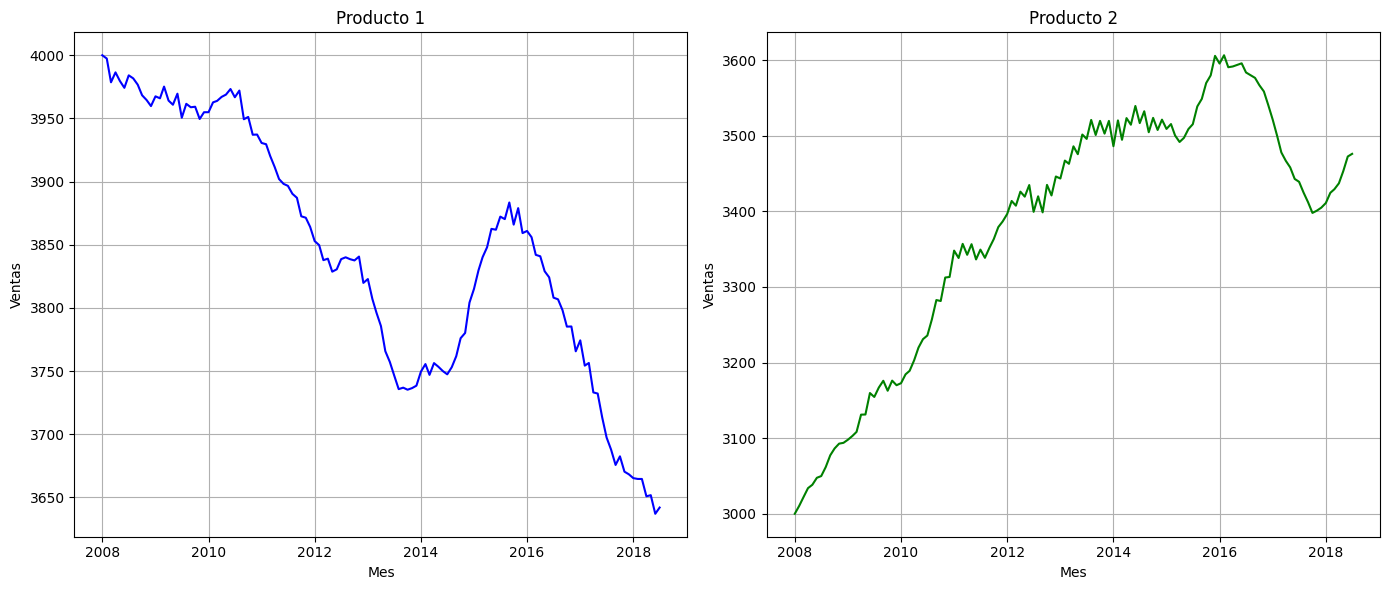

In [5]:
# Convertir la columna 'Mes' a tipo datetime si no lo está
data['Mes'] = pd.to_datetime(data['Mes'])

# Crear una figura con dos subplots (uno para cada producto)
plt.figure(figsize=(14, 6))

# Gráfico para producto 1
plt.subplot(1, 2, 1)
plt.plot(data['Mes'], data['producto1'], color='blue')  # Eliminamos marker='o'
plt.title('Producto 1')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Gráfico para producto 2
plt.subplot(1, 2, 2)
plt.plot(data['Mes'], data['producto2'], color='green')  # Eliminamos marker='o'
plt.title('Producto 2')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()

# Mostrar las gráficas
plt.show()


### **Componentes de las series de tiempo**

In [6]:
product_1_df = data[['producto1']]
product_1_df.index = data['Mes']
# --------------------------------------
product_2_df = data[['producto2']]
product_2_df.index = data['Mes']



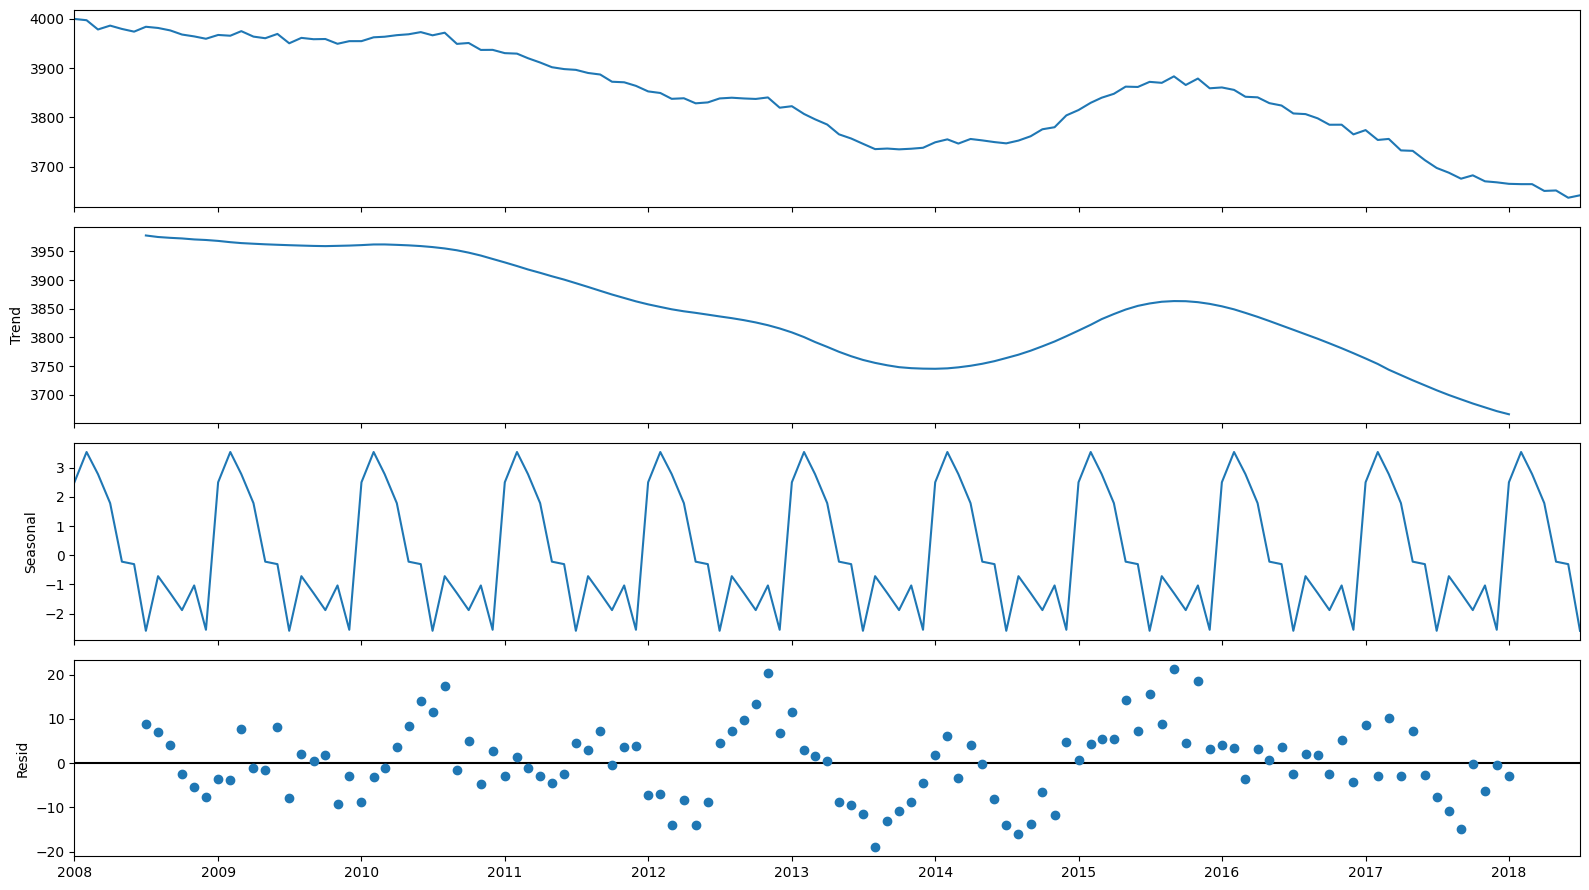

In [7]:
td_componentes = seasonal_decompose(product_1_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

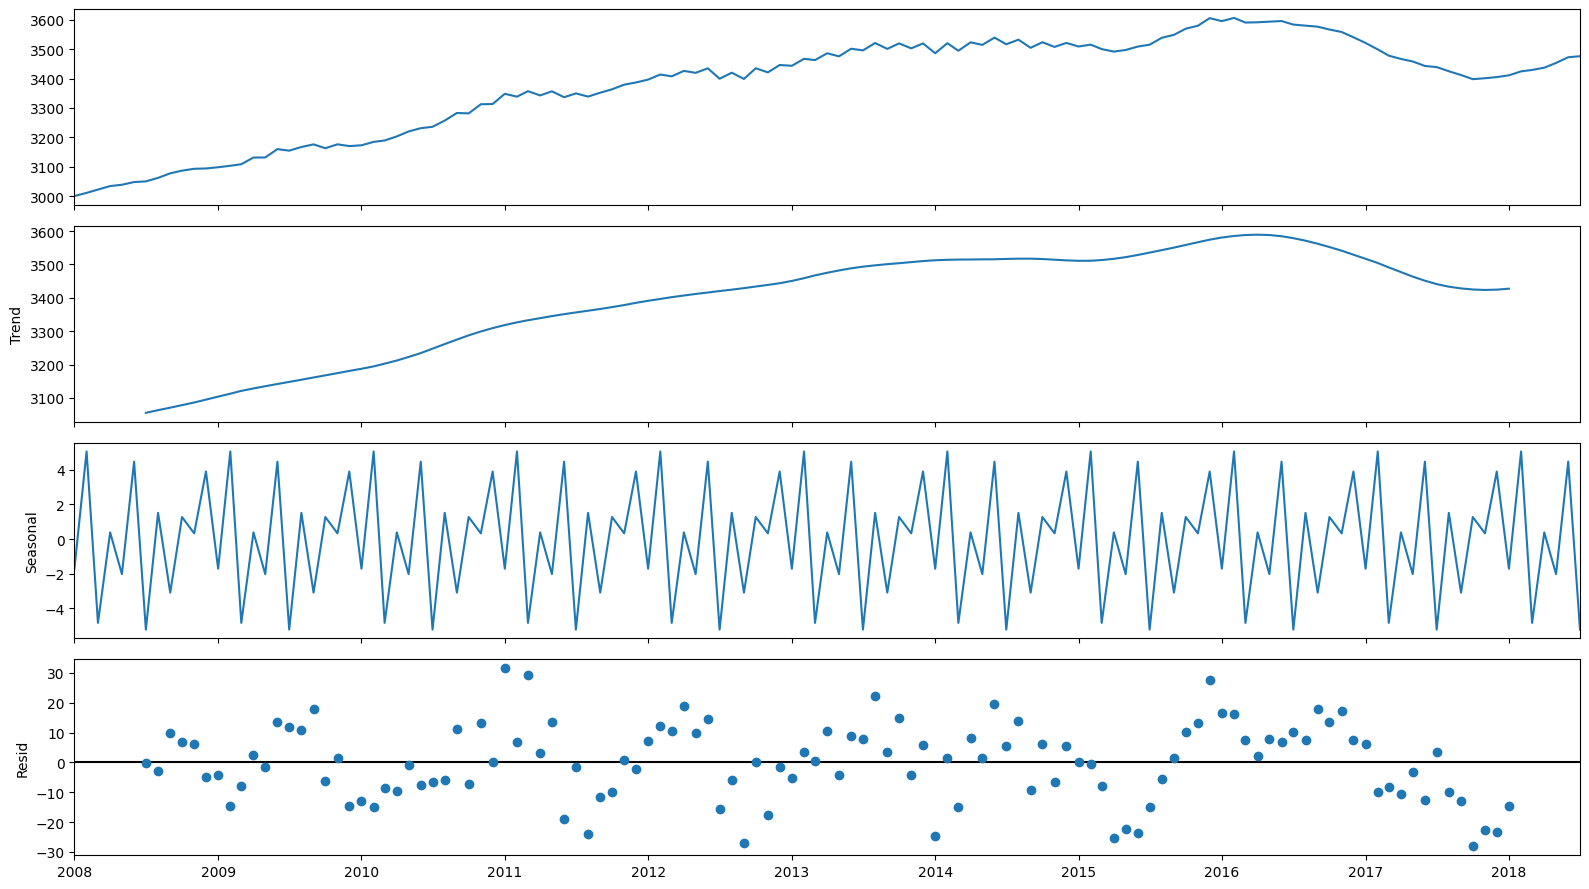

In [8]:
td_componentes = seasonal_decompose(product_2_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

# **Sección 4 - Protocólo de Evaluación**

### Configuración global
- Iteraciones: 10
- Predicción: 1

In [9]:
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

### Función Protocolo de Evaluación - Ventana Móvil

In [10]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(model_class, data, target_column, initial_train_size, num_iterations, forecast_horizon=1, **fit_args):
    print(fit_args)
    test_errors = []
    forecasts = []
    
    best_model = None
    lowest_error = float('inf')

    for i in range(num_iterations):
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Instantiate and fit the model
        model = model_class(y_train, **fit_args).fit()

        # Forecast the next point(s)
        test_predictions = model.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])  # Storing the first forecast value

        # Calculate the test error
        test_error = mean_squared_error(y_test, test_predictions)
        test_errors.append(test_error)

        # Check if this model has the lowest error and store it
        if test_error < lowest_error:
            lowest_error = test_error
            best_model = model

    return test_errors, forecasts, best_model


### Función para graficar los valores predichos

In [11]:
import matplotlib.pyplot as plt

def plot_forecast(data, forecasts, train_size):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    # Full plot with highlighted forecast section
    ax[0].plot(data.index, data, label='Actual Data', color='blue')
    forecast_indices = range(train_size, train_size + len(forecasts))
    ax[0].plot(forecast_indices, forecasts, label='Forecast', color='orange')
    ax[0].axvspan(train_size, train_size + len(forecasts), color='gray', alpha=0.3)
    ax[0].set_title('Actual Data with Forecast Overlay')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    ax[0].grid(True)

    # Zoomed-in section on forecast
    ax[1].plot(forecast_indices, data[train_size:train_size + len(forecasts)], label='Actual Data (Zoomed)', color='blue')
    ax[1].plot(forecast_indices, forecasts, label='Forecast (Zoomed)', color='orange')
    ax[1].set_title('Zoomed-In Forecast Section')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    ax[1].grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# **Sección 5 - Desarrollo de Modelos**

## **Despligue para Producto 1**

### 5.1 Promedio Móvil

In [12]:
import pandas as pd
import numpy as np

class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window
        self.fittedvalues = None

    def fit(self):
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


moving_average_test_errors, moving_average_forecasts, moving_average_model = rolling_window_evaluation(
    model_class=MovingAverageModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    window=3
)

moving_average_rmse = np.sqrt(np.mean(moving_average_test_errors))
print(f"Promedio móvil RMSE: {moving_average_rmse}")
print(moving_average_model)


{'window': 3}
Promedio móvil RMSE: 9.680204135597737


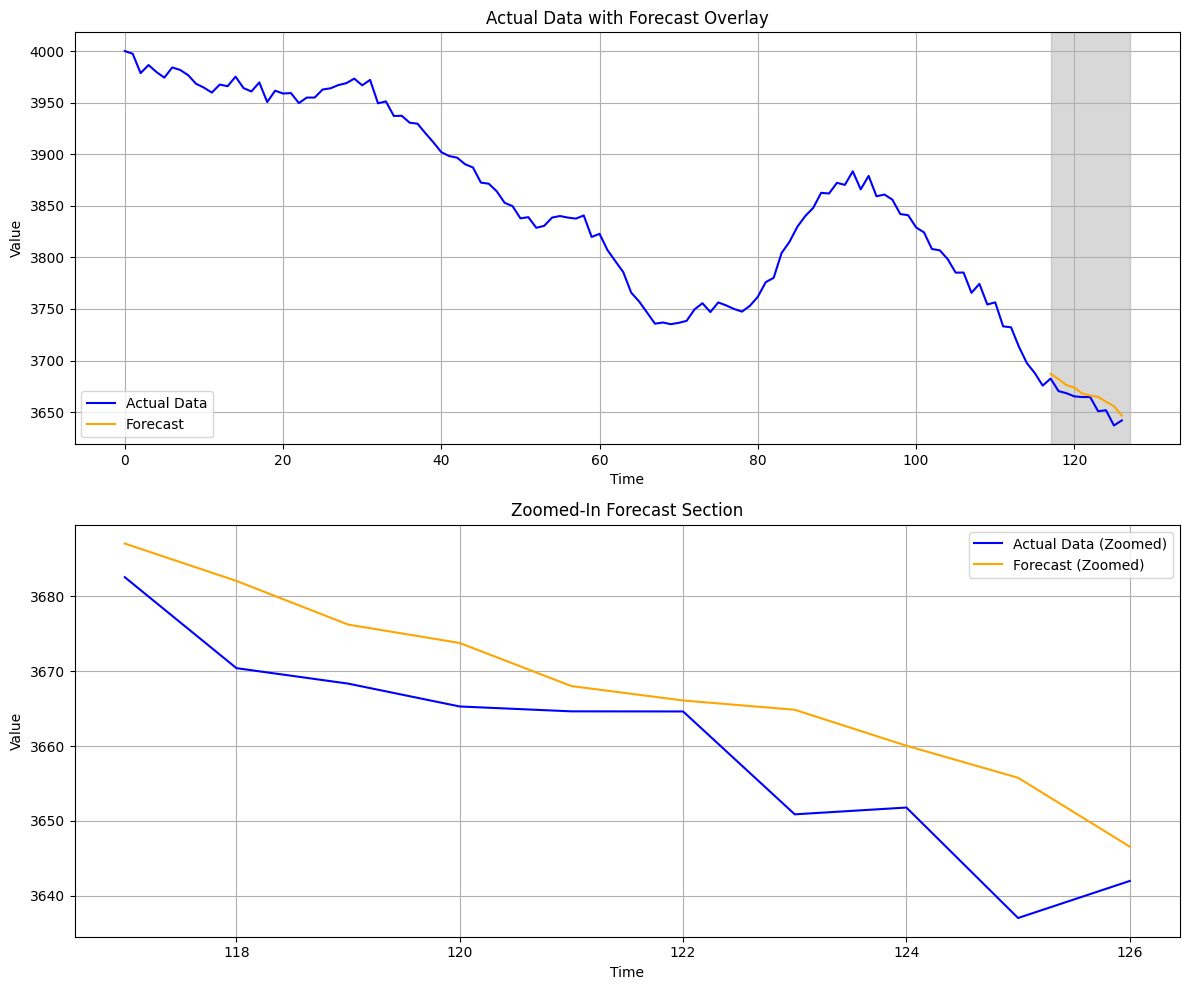

In [13]:
plot_forecast(data['producto1'], moving_average_forecasts, train_size)

## **5.2 Suavización Exponencial Holt Winters**

Con el objetivo de encontrar o más bien seleccionar los mejores hiperparámetros, llevaremos a cabo la aplicación de la técnica **Optimización Bayesiana**

In [14]:
# Buscando facilitar el uso de la técnica de optimización bayesiana procedemos a separar el dataset según el producto a utilizar:

# Crear el dataset con 'Mes' y 'producto1'
data_producto1 = data[['Mes', 'producto1']].set_index('Mes')

# Crear el dataset con 'Mes' y 'producto2'
data_producto2 = data[['Mes', 'producto2']].set_index('Mes')

#Frecuencia
data_producto1.index = pd.to_datetime(data_producto1.index)
data_producto1 = data_producto1.asfreq('MS')  # Mes

data_producto2.index = pd.to_datetime(data_producto2.index)
data_producto2 = data_producto2.asfreq('MS')  # Mes

# Mostrar los primeros datos para verificar
print(data_producto1.head())
print(data_producto2.head())


              producto1
Mes                    
2008-01-01  4000.000000
2008-02-01  3997.400893
2008-03-01  3978.605317
2008-04-01  3986.454125
2008-05-01  3979.695678
              producto2
Mes                    
2008-01-01  3000.000000
2008-02-01  3010.686220
2008-03-01  3022.018584
2008-04-01  3033.920990
2008-05-01  3038.402098


In [15]:
def train_and_evaluate_RMSE_bayes(error, trend, seasonal, alpha, beta, gamma):
    """Function we want to maximize (Black box)"""

    train_data = data_producto1[:len(data_producto1)-10]
    test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]

    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]

    # Asegúrate de que el índice tenga una frecuencia definida
    if train_data.index.freq is None:
        train_data = train_data.asfreq('D')  # Ajusta 'D' a la frecuencia que corresponda

    model = ETSModel(
        endog=train_data[train_data.columns[0]],
        error=error1[round(error)],
        trend=trend1[round(trend)],
        seasonal=seasonal1[round(seasonal)],
        seasonal_periods=12  # Ajusta según sea necesario
    )

    params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

    if trend1[round(trend)] is None:
        params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] is None:
        params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast = model_result.forecast(10)
    rmse = np.sqrt(mean_squared_error(test_data, point_forecast))

    print(f"target es: {rmse}, Error test: {error1[round(error)]}, Trend test: {trend1[round(trend)]}, Seasonal test: {seasonal1[round(seasonal)]}, Alpha model: {alpha}, Beta model: {beta}, Gamma model: {gamma}")

    return -rmse


In [16]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [17]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [18]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
target es: 72.48737026802618, Error test: add, Trend test: add, Seasonal test: add, Alpha model: 0.42, Beta model: 0.72, Gamma model: 0.31
| 1         | -72.49    | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
target es: 60.641442100971744, Error test: add, Trend test: mul, Seasonal test: mul, Alpha model: 0.19, Beta model: 0.35, Gamma model: 0.54
| 2         | -60.64    | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
target es: 186.1726399076884, Error test: add, Trend test: mul, Seasonal test: mul, Alpha model: 0.21, Beta model: 0.87, Gamma model: 0.67
| 3         | -186.2    | 0.2104    | 0.8706    | 0.02739   | 0.6671    | 0.8346    | 1.117     |
target es: 54.32002028801925, Error test: add, Trend test: add, Seasonal test: None, Alpha m

In [19]:
optimizer.max

{'target': -6.024658946493644,
 'params': {'alpha': 0.30195246569030304,
  'beta': 0.01,
  'error': 0.0,
  'gamma': 0.7876834379173638,
  'seasonal': 1.2950770402008143,
  'trend': 1.1477609700925209}}

In [20]:
'''import pandas as pd
import numpy as np
from itertools import product
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

# Configuración de parámetros para el modelo ETS
error_options = ["add", "mul"]
trend_options = ["add", None, "mul"]
seasonal_options = ["add", None, "mul"]


data_copy = data.copy()
data_copy['Mes'] = pd.to_datetime(data_copy['Mes'])
data_copy = data_copy.set_index('Mes')
data_copy = data_copy.asfreq('MS')

results = []

# Evaluar cada combinación de parámetros
for error, trend, seasonal in product(error_options, trend_options, seasonal_options):
    print(f"Evaluando configuración - Error: {error}, Trend: {trend}, Seasonal: {seasonal}")
    # Ejecutar la evaluación de ventana móvil
    errors, forecasts, model = rolling_window_evaluation(
		model_class=ETSModel,
		data=data_copy,
		target_column='producto1',
		initial_train_size=train_size,
		num_iterations=iterations,
		forecast_horizon=horizon,
		error=error,
		trend=trend,
		seasonal=seasonal
    )
    
    # Calcular el RMSE medio
    mean_rmse = np.sqrt(np.mean(errors))
    
    results.append({
        "Error": error,
        "Trend": trend,
        "Seasonal": seasonal,
        "Mean RMSE": mean_rmse,
        "forecasts": forecasts,
        "model": model,
    })

# Convertir resultados a DataFrame para su análisis
results_df = pd.DataFrame(results)
print("\nResultados de todas las combinaciones:")
print(results_df)

# Encontrar la mejor configuración
best_params = results_df.loc[results_df['Mean RMSE'].idxmin()]
print("\nMejor combinación de parámetros:")
print(best_params)'''

'import pandas as pd\nimport numpy as np\nfrom itertools import product\nfrom statsmodels.tsa.exponential_smoothing.ets import ETSModel\nfrom sklearn.metrics import mean_squared_error\n\n# Configuración de parámetros para el modelo ETS\nerror_options = ["add", "mul"]\ntrend_options = ["add", None, "mul"]\nseasonal_options = ["add", None, "mul"]\n\n\ndata_copy = data.copy()\ndata_copy[\'Mes\'] = pd.to_datetime(data_copy[\'Mes\'])\ndata_copy = data_copy.set_index(\'Mes\')\ndata_copy = data_copy.asfreq(\'MS\')\n\nresults = []\n\n# Evaluar cada combinación de parámetros\nfor error, trend, seasonal in product(error_options, trend_options, seasonal_options):\n    print(f"Evaluando configuración - Error: {error}, Trend: {trend}, Seasonal: {seasonal}")\n    # Ejecutar la evaluación de ventana móvil\n    errors, forecasts, model = rolling_window_evaluation(\n\t\tmodel_class=ETSModel,\n\t\tdata=data_copy,\n\t\ttarget_column=\'producto1\',\n\t\tinitial_train_size=train_size,\n\t\tnum_iterations=i

In [21]:
'''best_params = results_df.loc[results_df['Mean RMSE'].idxmin()]
print("\nMejor combinación de parámetros:")
print(best_params)'''

'best_params = results_df.loc[results_df[\'Mean RMSE\'].idxmin()]\nprint("\nMejor combinación de parámetros:")\nprint(best_params)'

In [22]:
'''plot_forecast(data['producto1'], best_params['forecasts'], train_size)'''

"plot_forecast(data['producto1'], best_params['forecasts'], train_size)"